In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scripts.utils import trigonometric_date_encoding, add_seasonality, create_lags, frac_diff_stationarity

2023-12-08 11:28:20.292760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Read in the CSV data
df = pd.read_csv('/Users/francescomattioli/Library/CloudStorage/OneDrive-PolitecnicodiMilano/UNI/MAGISTRALE/SECONDO ANNO/PRIMO SEMESTRE/DATA MINING & TIME SERIES/Project/Stock_Market_TS_Prediction/data/sp500/csv/AAPL.csv')

In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps - 1):
        end = i + n_steps
        seq_x, seq_y = data.iloc[i:end,:].values, data.iloc[end]["Close"]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(by="Date")

# Extract the year, month, and day as separate columns
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df = df.drop(columns=["Adjusted Close"])

In [ ]:
df = add_seasonality(df)

/Users/nicolacecere/opt/anaconda3/envs/DMTS/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nicolacecere/opt/anaconda3/envs/DMTS/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nicolacecere/opt/anaconda3/envs/DMTS/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nicolacecere/opt/anaconda3/envs/DMTS/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10590 non-null  datetime64[ns]
 1   Low                     10590 non-null  float64       
 2   Open                    10590 non-null  float64       
 3   Volume                  10590 non-null  int64         
 4   High                    10590 non-null  float64       
 5   Close                   10590 non-null  float64       
 6   Year                    10590 non-null  int32         
 7   Month                   10590 non-null  int32         
 8   Day                     10590 non-null  int32         
 9   Month_Category_Bearish  10590 non-null  float64       
 10  Month_Category_Bullish  10590 non-null  float64       
 11  Month_Category_Normal   10590 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int32(3), in

In [ ]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
train = df.iloc[:train_size, :]
val = df.iloc[train_size : train_size + val_size, :]
test = df.iloc[train_size + val_size :, :]

In [ ]:
train_copy = train.copy()
train, val = frac_diff_stationarity(train, val)
train, test = frac_diff_stationarity(train_copy, test)

In [ ]:
'''
train = create_lags(train, 3)
val = create_lags(val, 3)
test = create_lags(test, 3)
'''

In [ ]:
train = trigonometric_date_encoding(train)
val = trigonometric_date_encoding(val)
test = trigonometric_date_encoding(test)
train = train.drop(["Date"], axis=1)
val = val.drop(["Date"], axis=1)
test = test.drop(["Date"], axis=1)

In [ ]:
train.head()

,Low,Open,Volume,High,Close,Year,Month,Day,Month_Category_Bearish,Month_Category_Bullish,Month_Category_Normal,lag_1,lag_2,lag_3,sin_date,cos_date
0,0.128348,0.128348,469033600,0.128906,0.128348,1980,12,12,1.0,0.0,0.0,0.128348,0.128348,0.128348,-0.433884,-0.900969
1,0.121652,0.122210,175884800,0.122210,0.121652,1980,12,15,1.0,0.0,0.0,0.128348,0.128348,0.128348,0.000000,1.000000
2,0.112723,0.113281,105728000,0.113281,0.112723,1980,12,16,1.0,0.0,0.0,0.121652,0.128348,0.128348,0.781831,0.623490
3,0.115513,0.115513,86441600,0.116071,0.115513,1980,12,17,1.0,0.0,0.0,0.112723,0.121652,0.128348,0.974928,-0.222521
4,0.118862,0.118862,73449600,0.119420,0.118862,1980,12,18,1.0,0.0,0.0,0.115513,0.112723,0.121652,0.433884,-0.900969


In [ ]:
excluded_columns = ["sin_date", "cos_date"]
features_to_standardize = [column for column in train.columns if column not in excluded_columns]


# Calculate the mean and standard deviation only for the required columns
train_mean = train[features_to_standardize].mean()
train_std = train[features_to_standardize].std()

# Standardize only the required columns in the train, validation, and test sets
train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std

In [ ]:
features_to_standardize

['Low',
 'Open',
 'Volume',
 'High',
 'Close',
 'Year',
 'Month',
 'Day',
 'lag_1',
 'lag_2',
 'lag_3']

In [ ]:
X_train, y_train = create_sequences(train, 5)
X_val, y_val = create_sequences(val, 5)
X_test, y_test = create_sequences(test, 5)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8466, 5, 16), (8466,), (1053, 5, 16), (1053,), (1053, 5, 16), (1053,))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_simple_LSTM_regressor(input_shape, output_units=1):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # LSTM layer
    lstm = tfkl.LSTM(16, activation='leaky_relu', return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(16, activation='leaky_relu')(lstm)

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(lstm)  # Single unit for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Simple_LSTM_regressor')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Return the model
    return model

# Assuming input_shape is (5, n_features)
input_shape = (X_train.shape[1], X_train.shape[2])  
output_units = 1

# Build and compile the model
model = build_simple_LSTM_regressor(input_shape, output_units)
model.summary()


# Train the model
history = model.fit(
x=X_train,
y=y_train,
batch_size=64,
validation_data=(X_val, y_val),
epochs=50,
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
]
).history


Model: "Simple_LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 16)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 16)             2112      
                                                                 
 lstm_7 (LSTM)               (None, 16)                2112      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4241 (16.57 KB)
Trainable params: 4241 (16.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 3s 6ms/step - loss: 0.1538 - mae: 0.2427 - val_loss: 0.2403 - val_mae: 0.3779 - lr: 0.001

In [ ]:
test_loss = model.evaluate(X_test, y_test, verbose=1)

33/33 [==============================] - 0s 3ms/step - loss: 0.8998 - mae: 0.7079


33/33 [==============================] - 0s 1ms/step


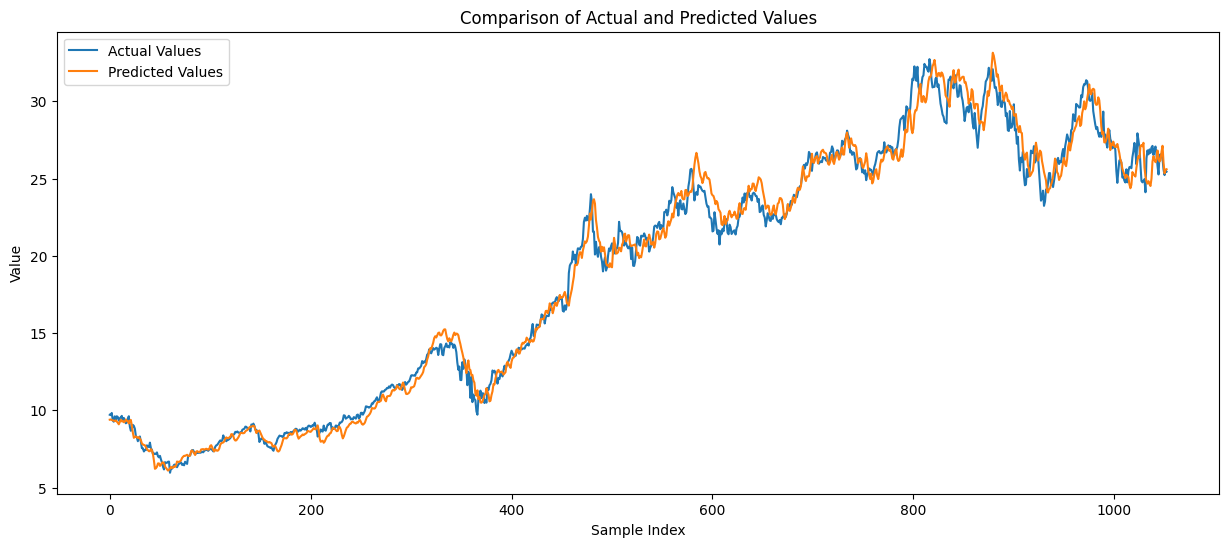

In [ ]:
y_pred = model.predict(X_test)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

 1/33 [..............................] - ETA: 0s

33/33 [==============================] - 0s 2ms/step


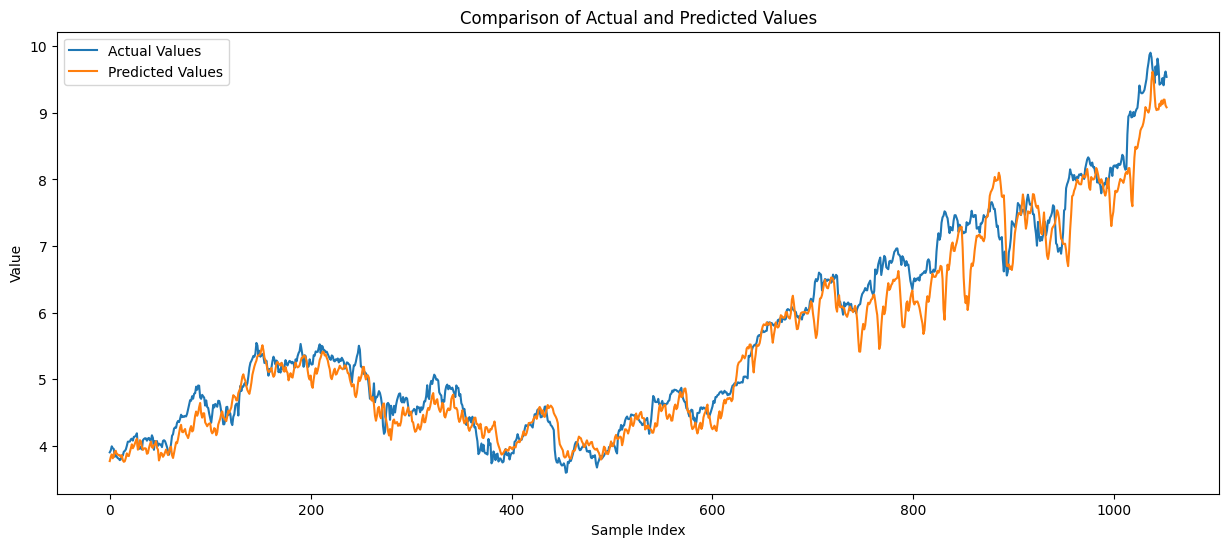

In [ ]:
y_pred = model.predict(X_val)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

  1/265 [..............................] - ETA: 6s

265/265 [==============================] - 1s 2ms/step


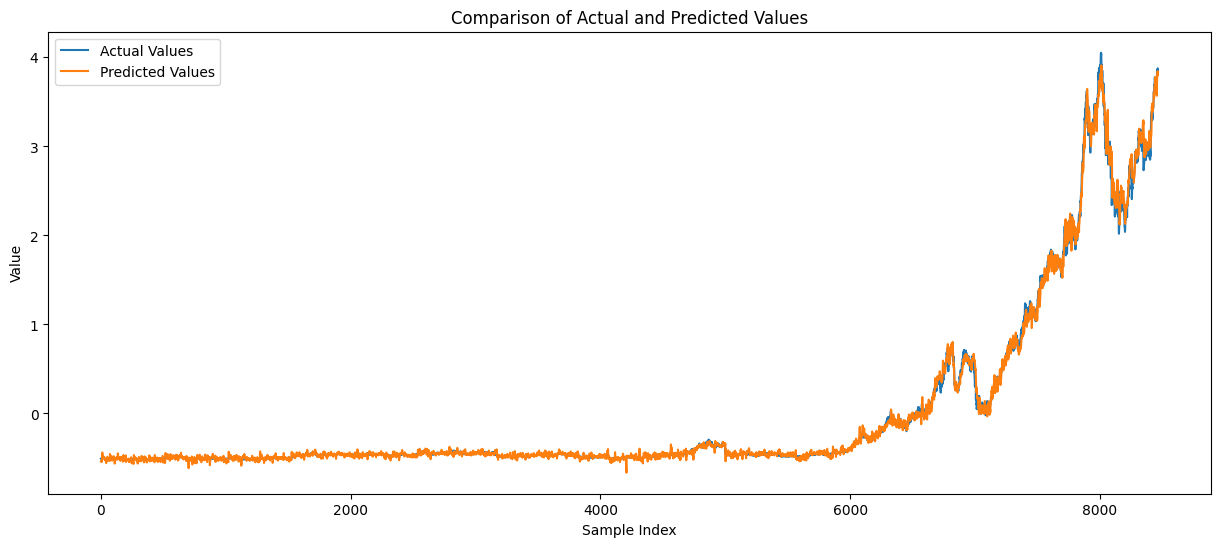

In [ ]:
y_pred = model.predict(X_train)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_train, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()